In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn import metrics
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score

In [2]:
car_df = pd.read_csv("car.csv", na_values='?')
car_df.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,US Made
0,18.0,8,307.0,130.0,3504,12.0,70,1
1,15.0,8,350.0,165.0,3693,11.5,70,1
2,18.0,8,318.0,150.0,3436,11.0,70,1
3,16.0,8,304.0,150.0,3433,12.0,70,1
4,17.0,8,302.0,140.0,3449,10.5,70,1


In [3]:
car_df.shape

(398, 8)

In [4]:
car_df.describe()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,US Made
count,398.000000,398.000000,398.000000,392.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,104.469388,2970.424623,15.568090,76.010050,0.625628
std,7.815984,1.701004,104.269838,38.491160,846.841774,2.757689,3.697627,0.484569
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,0.000000
25%,17.500000,4.000000,104.250000,75.000000,2223.750000,13.825000,73.000000,0.000000
50%,23.000000,4.000000,148.500000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,126.000000,3608.000000,17.175000,79.000000,1.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,1.000000


## Data Cleaning

In [5]:
# Checking null values
car_df.isnull().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
US Made         0
dtype: int64

In [6]:
car_df.duplicated().value_counts()

False    398
dtype: int64

In [7]:
# Imputing missing values in 'Horsepower' with the median
median_hp = car_df['Horsepower'].median()
car_df['Horsepower'].fillna(median_hp, inplace=True)

# Rechecking for missing values
car_df.isnull().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      0
Weight          0
Acceleration    0
Model Year      0
US Made         0
dtype: int64

In [8]:
car_df.shape

(398, 8)

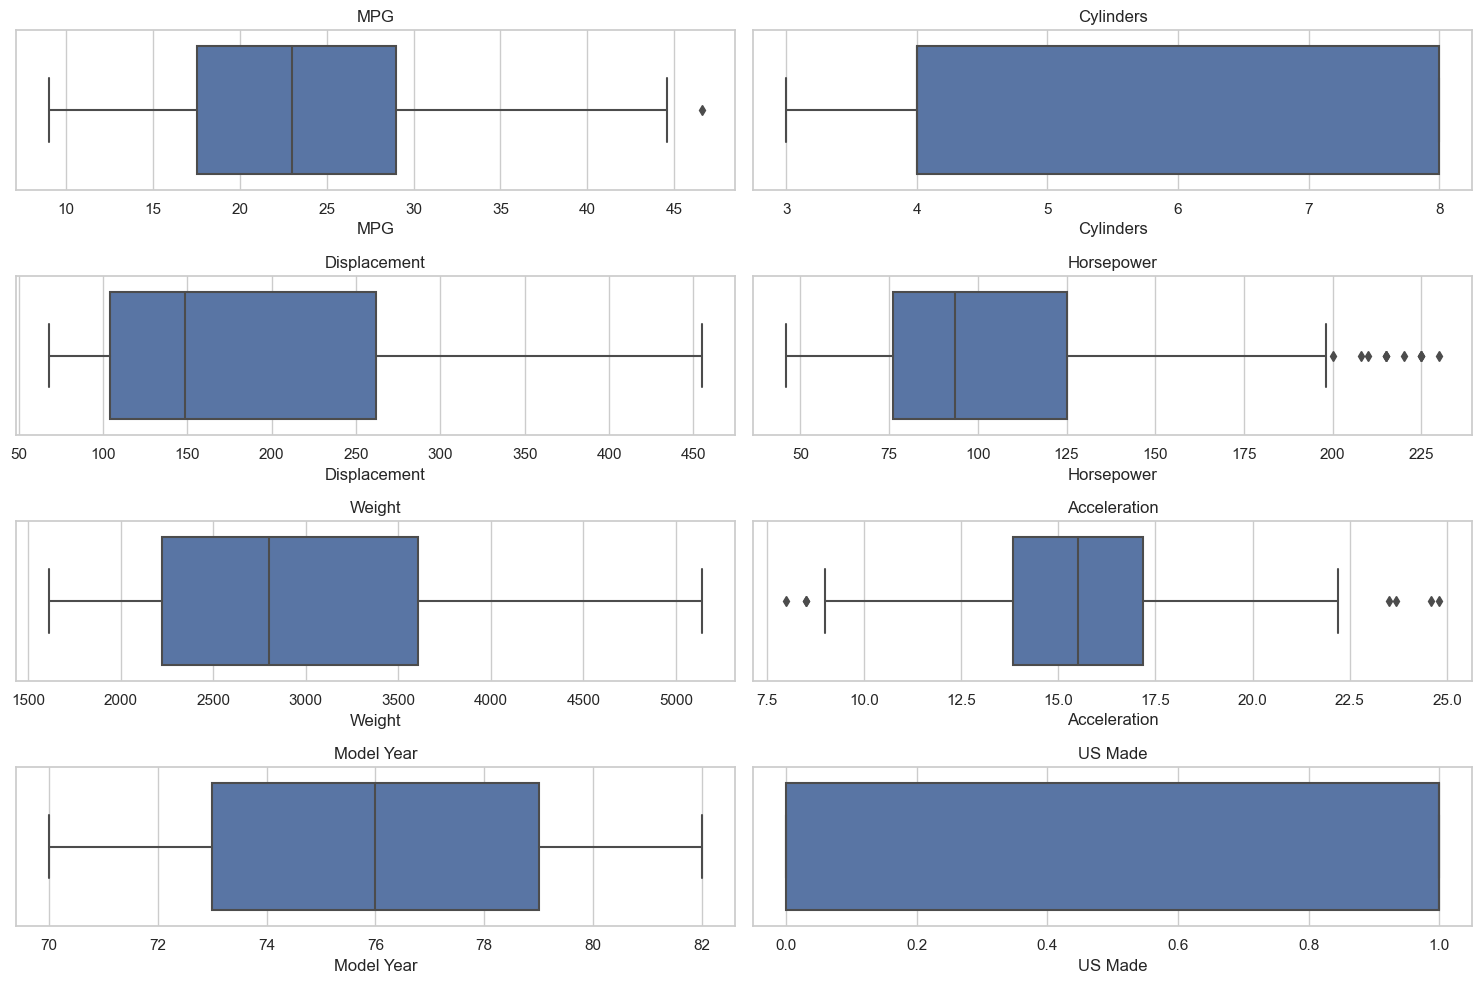

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setting the aesthetics for the plots
sns.set(style="whitegrid")

# Creating boxplots for each numeric column to identify outliers
numeric_columns = car_df.select_dtypes(include=['float64', 'int64']).columns
n_cols = len(numeric_columns)

plt.figure(figsize=(15, 10))

for i, col in enumerate(numeric_columns):
    plt.subplot((n_cols + 1) // 2, 2, i + 1)
    sns.boxplot(x=car_df[col])
    plt.title(col)

plt.tight_layout()
plt.show()


In [10]:
# Calculate IQR for each numeric column
Q1 = car_df.quantile(0.25)
Q3 = car_df.quantile(0.75)
IQR = Q3 - Q1

# Identifying outliers
outliers = ((car_df < (Q1 - 1.5 * IQR)) | (car_df > (Q3 + 1.5 * IQR))).sum()
outliers[outliers > 0]


MPG              1
Horsepower      11
Acceleration     7
dtype: int64

In [11]:
# Handling outliers by capping/flooring them to the nearest non-outlier value
car_df_capped = car_df.copy()

for column in ['MPG', 'Horsepower', 'Acceleration']:
    lower_bound = Q1[column] - 1.5 * IQR[column]
    upper_bound = Q3[column] + 1.5 * IQR[column]
    car_df_capped[column] = car_df[column].clip(lower=lower_bound, upper=upper_bound)


# Recheck the outliers count
outliers_after = ((car_df_capped < (Q1 - 1.5 * IQR)) | (car_df_capped > (Q3 + 1.5 * IQR))).sum()

outliers_after[outliers_after > 0]


Series([], dtype: int64)

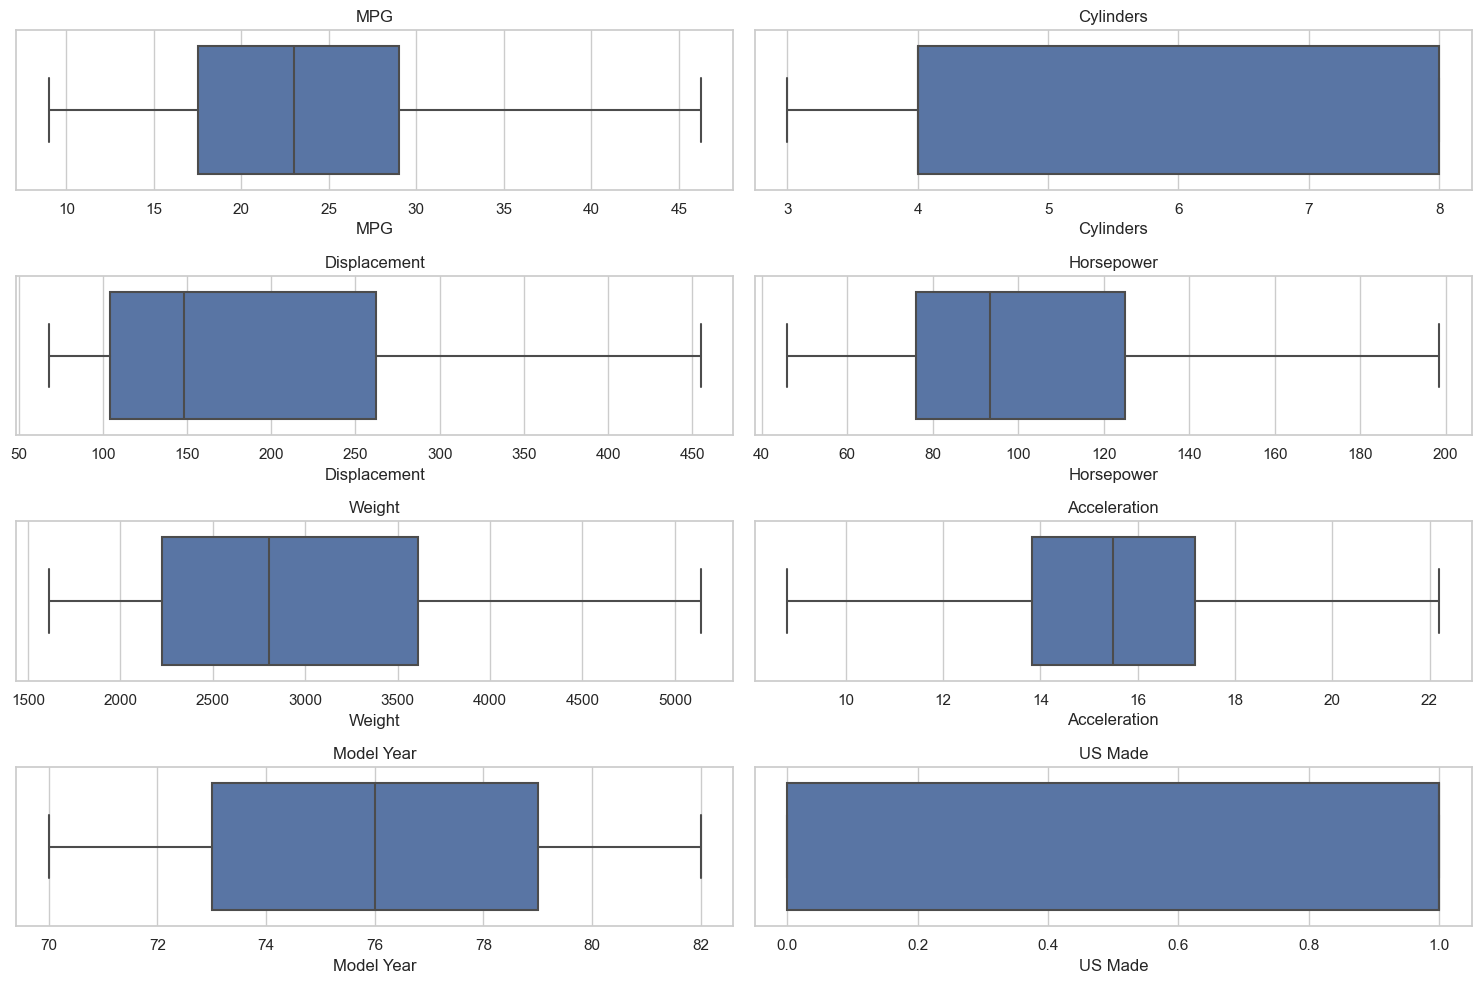

In [12]:
# Setting the aesthetics for the plots
sns.set(style="whitegrid")

# Creating boxplots for each numeric column to identify outliers
numeric_columns = car_df_capped.select_dtypes(include=['float64', 'int64']).columns
n_cols = len(numeric_columns)

plt.figure(figsize=(15, 10))

for i, col in enumerate(numeric_columns):
    plt.subplot((n_cols + 1) // 2, 2, i + 1)
    sns.boxplot(x=car_df_capped[col])
    plt.title(col)

plt.tight_layout()
plt.show()


## Building Linear Regression Model

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Splitting the dataset into features and the target variable
X = car_df_capped.drop('MPG', axis=1)  # Features
y = car_df_capped['MPG']               # Target

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Building the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Making predictions on the test set
y_pred = model.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

mse, rmse, r2


(8.242641445285546, 2.8710000775488576, 0.8466954317527176)

In [14]:
# Extracting the coefficients of the model
coefficients = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])

# Displaying the coefficients
coefficients.sort_values(by='Coefficient', ascending=False)

,Coefficient
Model Year,0.815581
Acceleration,0.022834
Displacement,0.019229
Weight,-0.006744
Horsepower,-0.023619
Cylinders,-0.149689
US Made,-2.825545


In [15]:
#importing the necessary libraries
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression

In [16]:
# Sequential Forward Selection(sfs)
sfs = SFS(LinearRegression(),
          k_features=(4),
          forward=True,
          floating=True,
          scoring = 'r2')

In [17]:
sfs.fit(X, y)
sfs.k_feature_names_ 

('Displacement', 'Weight', 'Model Year', 'US Made')

In [18]:
# Fit SFS on the training data
sfs = sfs.fit(X_train, y_train)

# Get the selected feature indices and print them
selected_features = list(sfs.k_feature_idx_)
print("Selected features:", selected_features)

# Build a new model using only the selected features
model_with_selected_features = LinearRegression()
model_with_selected_features.fit(X_train.iloc[:, selected_features], y_train)

# Make predictions and evaluate the model
y_pred_selected = model_with_selected_features.predict(X_test.iloc[:, selected_features])
mse_selected = mean_squared_error(y_test, y_pred_selected)
rmse_selected = np.sqrt(mse_selected)
r2_selected = r2_score(y_test, y_pred_selected)

print("MSE:", mse_selected)
print("RMSE:", rmse_selected)
print("R^2:", r2_selected)

Selected features: [2, 3, 5, 6]
MSE: 8.632751982722414
RMSE: 2.9381545198852996
R^2: 0.8394397810116945
